# Enterprise Dataset Inventory Analysis

This notebook presents the code used to generate the Enterprise Dataset Inventory (EDI) analysis in the [Chief Data Officer's Annual Report](http://opendata.dc.gov/pages/cdo-annual-report) published on March 11, 2018. The EDI and Annual Report fulfill the requirements of the [District of Columbia Data Policy](https://octo.dc.gov/page/district-columbia-data-policy) enacted by Mayor Muriel Bowser on April 27, 2017. 

The report requires two archived datasets available in [this GitHub repository](https://github.com/DCgov/enterprise-dataset-inventory/tree/master/fy18-annual-report/data): 

[agency_participants.csv](https://github.com/DCgov/enterprise-dataset-inventory/blob/master/fy18-annual-report/data/agency_participants_archived.csv) contains a list of agency names, acronyms, whether the agency is mayoral or non-mayoral, and whether or not the agency participated in the 2017-18 Enterprise Dataset Inventory. 

[dataset_inventory_2018_03_11.csv](https://github.com/DCgov/enterprise-dataset-inventory/blob/master/fy18-annual-report/data/dataset_inventory_2018_03_11.csv) contains an archived copy of the data table derived from the Enterprise Dataset Inventory on the day of the report's publication. A continually-updated copy of this dataset is available on the [DC Open Data Portal](http://opendata.dc.gov/datasets/enterprise-dataset-inventory) and can be analyzed [using this notebook](https://github.com/DCgov/enterprise-dataset-inventory/blob/master/report-updated.ipynb).

The report was generated in Python 3.6.3 and requires the following packages: Pandas, NumPy, Matplotlib, and Seaborn.

Please report any issues to the GitHub repository [here](https://github.com/DCgov/enterprise-dataset-inventory/issues). 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font='DejaVu Sans')

np.set_printoptions(suppress=True)

## Import Data

In [2]:
participation = pd.read_csv('data/agency_participants_archived.csv')

In [3]:
df = pd.read_csv('data/dataset_inventory_2018_03_11.csv')

## When was the most recent record published?

In [4]:
print('Data Last Pulled: '+pd.to_datetime(df.PUBLISHED_DATE).max().strftime("%Y/%m/%d"))

Data Last Pulled: 2018/03/11


## Assigning OCTO Data to Data Owners

The Office of the Chief Technology Officer (OCTO) maintains and publishes a large number of datasets for DC government agencies. For the sake of the inventory, OCTO largely attributed ownership of these datasets to the originating agency. This function cleans up data ownership and ensures that datasets are properly attributed in the analysis. Datasets maintained or published by OCTO that originate with non-DC government agencies (e.g., federal agencies) are assigned to OCTO as the data owner for the sake of this analysis.

In [5]:
not_dc  = ['AOC', 'BID', 'CENSUS', 'CT', 'MWCOG', 'NCPC', 'NGA', 'NPS', 'USDA', 'USDOT', 'USFWS', 'USGS', 'USPS', 'WDCEP', 'WMATA']

def data_owner(x):
    if x.AGENCY_ACRONYM in not_dc:
        return 'OCTO'
    elif (x.AGENCY_ACRONYM == 'OCTO') and ('DCEO' in x.DATA_OWNER):
        return 'DOEE'
    elif (x.AGENCY_ACRONYM == 'OCTO') and ('OA' in x.DATA_OWNER):
        return 'DCOA'
    elif (x.AGENCY_ACRONYM == 'OA'):
        return 'DCOA'
    elif (x.AGENCY_ACRONYM == 'OCTO') and ('NavTEQ' in x.DATA_OWNER):
        return 'OCTO'
    elif (x.AGENCY_ACRONYM == 'OCTO') and ('OCTO' not in x.DATA_OWNER):
        return x.DATA_OWNER
    elif (x.AGENCY_ACRONYM == 'OCTO') and ('PASS' in x.DATA_OWNER):
        return 'OCP'
    else:
        return x.AGENCY_ACRONYM
    
df['AGENCYCODE'] = df.apply(lambda x: data_owner(x), axis = 1)

## How many agencies participated?

Number of datasets recorded: 1640
Total number of agencies: 99

Number of Agencies participating: 79
Percent of Agencies Participating: 79.8

Number of Mayoral Agencies: 69
Number of Mayoral Agencies Participating: 69
Percent of Mayoral Agencies Participating: 100.0

Number of Non-Mayoral Agencies: 30
Number of Non-Mayoral Agencies Participating: 10
Percent of Non-Mayoral Agencies Participating: 33.3


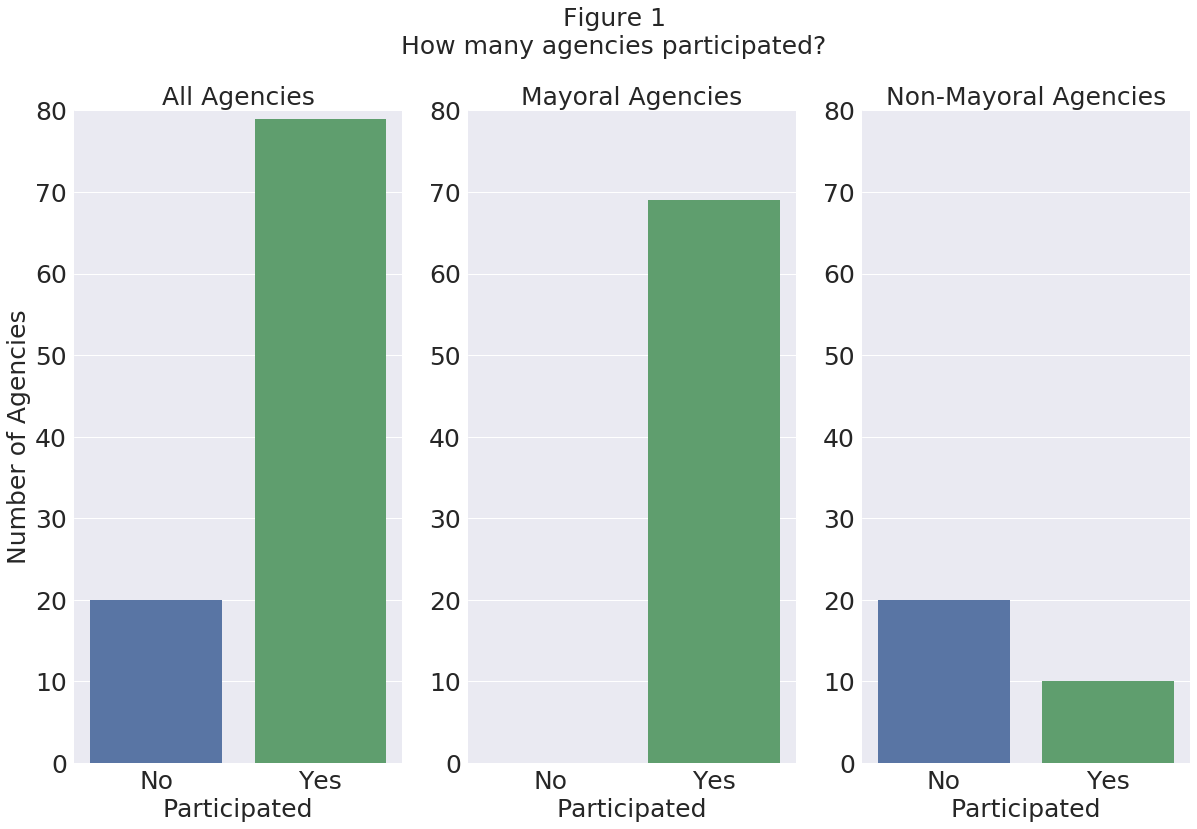

In [6]:
def participate(x):
    if 'No' in x.AGENCY_PARTICIPATING:
        return 'No'
    elif 'Yes' in x.AGENCY_PARTICIPATING:
        return 'Yes'
        
participation['PARTICIPATION'] = participation.apply(lambda x: participate(x), axis = 1)

mayoral = participation[participation.TYPE_OF_AGENCY=='Mayoral Agency']
nonmayoral = participation[participation.TYPE_OF_AGENCY=='Non-Mayoral Agency']

print('Number of datasets recorded: '+str(len(df)))
print('Total number of agencies: ' +str(len(participation)))

print('\nNumber of Agencies participating: '+str(np.round((participation.PARTICIPATION=='Yes').sum())))
print('Percent of Agencies Participating: '+str(100 * np.round((participation.PARTICIPATION=='Yes').sum()*1.0/participation.shape[0], 3)))

print('\nNumber of Mayoral Agencies: ' +str(np.round(mayoral.shape[0])))
print('Number of Mayoral Agencies Participating: ' +str(np.round((mayoral.PARTICIPATION=='Yes').sum())))
print('Percent of Mayoral Agencies Participating: ' +str(100 * np.round((mayoral.PARTICIPATION=='Yes').sum()*1.0/mayoral.shape[0], 3)))

print('\nNumber of Non-Mayoral Agencies: ' +str(np.round(nonmayoral.shape[0])))
print('Number of Non-Mayoral Agencies Participating: ' +str(np.round((nonmayoral.PARTICIPATION=='Yes').sum())))
print('Percent of Non-Mayoral Agencies Participating: ' +str(100 * np.round((nonmayoral.PARTICIPATION=='Yes').sum()*1.0/nonmayoral.shape[0], 3)))

fig, (ax, ax1, ax2) = plt.subplots(1,3,figsize = (20,12))

sns.barplot(np.sort(participation.PARTICIPATION.unique()), participation.PARTICIPATION.value_counts().sort_index(), ax=ax)
ax.set_xlabel('Participated', fontsize = 25)
ax.set_ylabel('Number of Agencies', fontsize = 25)
ax.set_title('All Agencies', fontsize = 25)
ax.tick_params(which = 'major', labelsize = 25)
ax.set_ylim(0,80)

if ('No' in mayoral.PARTICIPATION.unique()) and ('Yes' in mayoral.PARTICIPATION.unique()):
    x = np.sort(mayoral.PARTICIPATION.unique())
    y = mayoral.PARTICIPATION.value_counts().sort_index()
elif ('No' not in mayoral.PARTICIPATION.unique()) and ('Yes' in mayoral.PARTICIPATION.unique()):
    x = ['No', 'Yes']
    y = [0, mayoral.PARTICIPATION.value_counts().sort_index()]
elif ('No' in mayoral.PARTICIPATION.unique()) and ('Yes' not in mayoral.PARTICIPATION.unique()):
    x = ['No', 'Yes']
    y = [mayoral.PARTICIPATION.value_counts().sort_index(), 0]

sns.barplot(x, y, ax=ax1)
ax1.set_xlabel('Participated', fontsize = 25)
ax1.set_ylabel('', fontsize = 25)
ax1.set_title('Mayoral Agencies', fontsize = 25)
ax1.tick_params(which = 'major', labelsize = 25)
ax1.set_ylim(0,80)

if ('No' in nonmayoral.PARTICIPATION.unique()) and ('Yes' in nonmayoral.PARTICIPATION.unique()):
    x = np.sort(nonmayoral.PARTICIPATION.unique())
    y = nonmayoral.PARTICIPATION.value_counts().sort_index()
elif ('No' not in nonmayoral.PARTICIPATION.unique()) and ('Yes' in nonmayoral.PARTICIPATION.unique()):
    x = ['No', 'Yes']
    y = [0, nonmayoral.PARTICIPATION.value_counts().sort_index()]
elif ('No' in nonmayoral.PARTICIPATION.unique()) and ('Yes' not in nonmayoral.PARTICIPATION.unique()):
    x = ['No', 'Yes']
    y = [nonmayoral.PARTICIPATION.value_counts().sort_index(), 0]

sns.barplot(x, y, ax=ax2)
ax2.set_xlabel('Participated', fontsize = 25)
ax2.set_ylabel('', fontsize = 25)
ax2.set_title('Non-Mayoral Agencies', fontsize = 25)
ax2.tick_params(which = 'major', labelsize = 25)
ax2.set_ylim(0,80)
plt.suptitle('Figure 1\nHow many agencies participated?', fontsize = 25, y = 1.00)
plt.show()

## How many data sets did agencies enter?

OCTO    250
DCPS    168
DDOT    143
DOH     109
DOEE     76
OP       70
OCFO     55
DPW      39
DCRA     37
OUC      36
Name: AGENCYCODE, dtype: int64

Average Number of Data Sets: 21.6
Median Number of Data Sets: 9.5
Most Common Number of Data Sets: 2


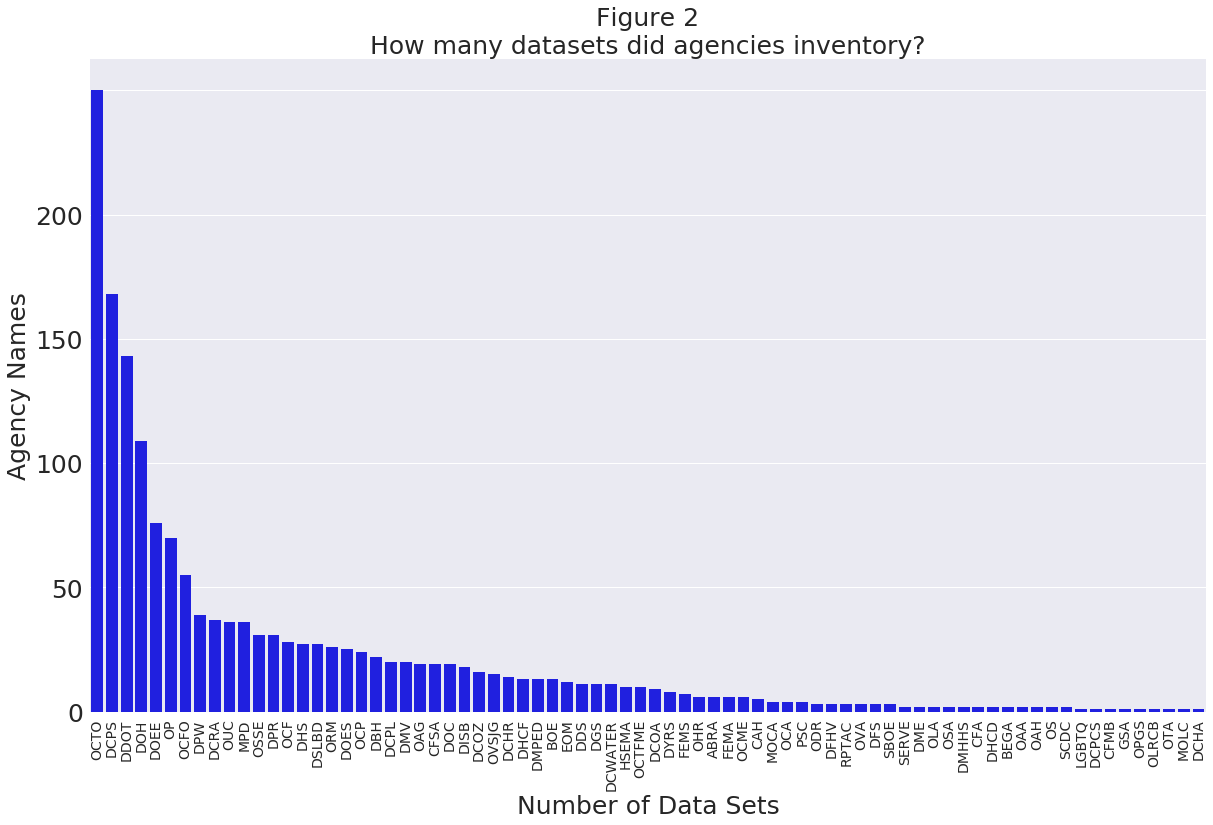

In [7]:
agency_counts = df.AGENCYCODE.value_counts()

print(agency_counts.sort_values(ascending=False).head(n=10))

print('\nAverage Number of Data Sets: '+str(round(df.AGENCYCODE.value_counts().mean(),1)))
print('Median Number of Data Sets: '+str(df.AGENCYCODE.value_counts().median()))
print('Most Common Number of Data Sets: '+str(df.AGENCYCODE.value_counts().mode().values[0]))

fig, ax = plt.subplots(figsize=(20,12))
sns.barplot(agency_counts.index, agency_counts.values, color='blue')
plt.xticks(rotation=90)
ax.set_xticklabels(agency_counts.index, fontsize=14)
ax.set_yticklabels(np.arange(0, 250, 50), fontsize=25)
ax.set_xlabel('Number of Data Sets', fontsize=25)
ax.set_ylabel('Agency Names', fontsize=25)
ax.set_title('Figure 2\nHow many datasets did agencies inventory?', fontsize=25)
plt.show()

## Dataset Classification

In [8]:
class_names = ['Open', 'Public Not Proactively Released', 'For District Government Use', 
               'Confidential', 'Restricted Confidential']
df['classification'] = df.DATASET_CLASSIFICATION_NAME.map({'Open': 0, 'Public Not Proactively Released': 1, 
                                                         'For District Government Use': 2, 'Confidential': 3, 
                                                         'Restricted Confidential': 4})

Number Classified
classification  DATASET_CLASSIFICATION_NAME    
0               Open                               708
1               Public Not Proactively Released    137
2               For District Government Use        193
3               Confidential                       508
4               Restricted Confidential             94
Name: classification, dtype: int64
Percent Classified
classification  DATASET_CLASSIFICATION_NAME    
0               Open                               43.2
1               Public Not Proactively Released     8.4
2               For District Government Use        11.8
3               Confidential                       31.0
4               Restricted Confidential             5.7
Name: classification, dtype: float64


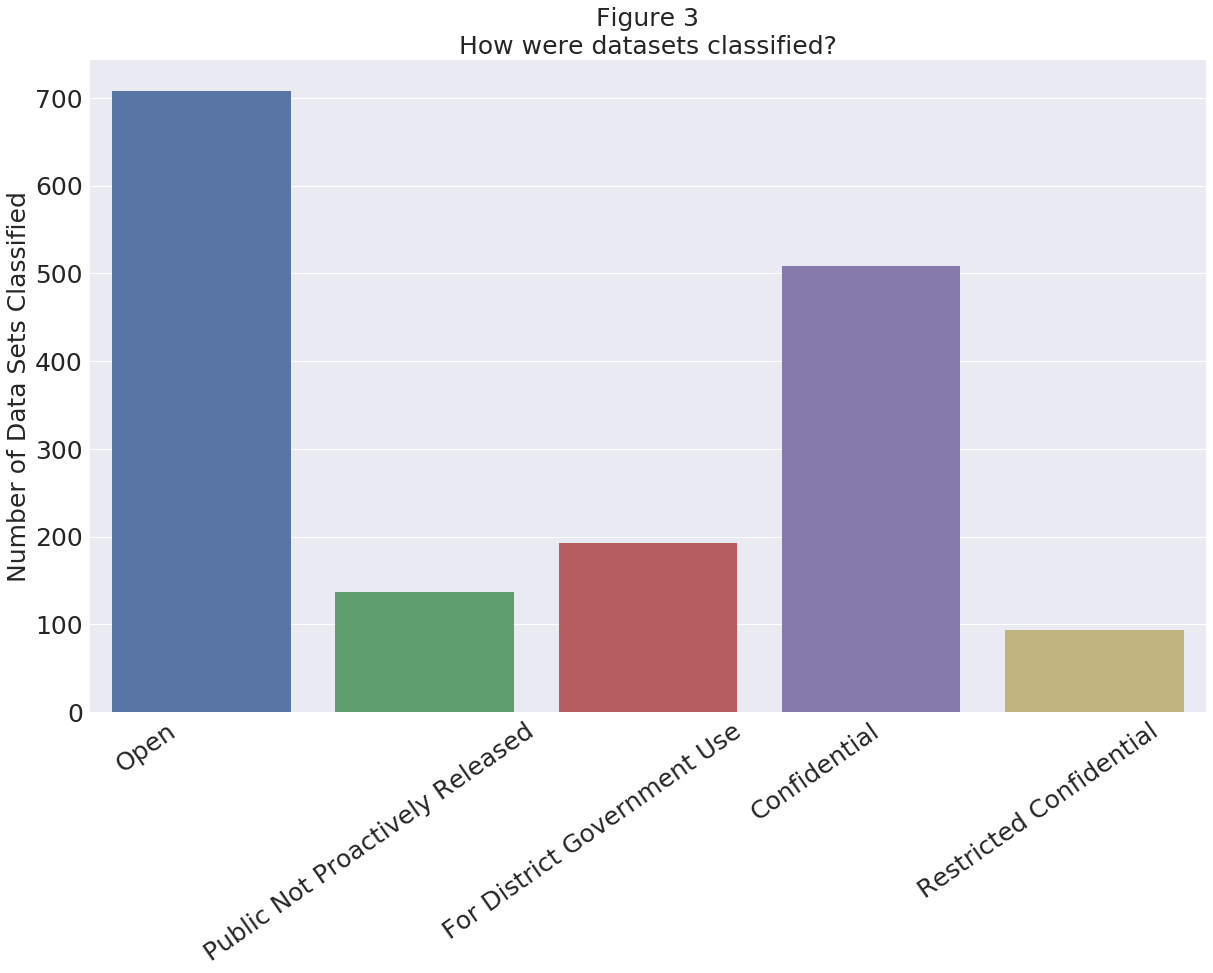

In [9]:
print('Number Classified')
print(np.round(df.groupby(['classification', 'DATASET_CLASSIFICATION_NAME']).classification.count(), 3))

print('Percent Classified')
print(100 * np.round(df.groupby(['classification', 'DATASET_CLASSIFICATION_NAME']).classification.count()/len(df), 3))

fig, ax = plt.subplots(figsize = (20,12))
sns.barplot(np.sort(df.classification.unique()), df.classification.value_counts().sort_index(), ax=ax)
ax.set_ylabel('Number of Data Sets Classified', fontsize=25)
ax.set_xticks(np.arange(-.25,4.75))
ax.set_xticklabels(class_names)
plt.xticks(rotation=35)
ax.tick_params(which = 'major', labelsize = 25)
ax.set_title('Figure 3\nHow were datasets classified?', fontsize = 25)

## How many Open Data Sets are in the Open Data Portal?

Data Sets in Open Data Portal: 517
Data Sets Classified 'Open': 708
Open Data Sets not in Open Data Portal: 191
No     191
Yes    517
Name: OPENDATA_PORTAL, dtype: int64
No     27.0
Yes    73.0
Name: OPENDATA_PORTAL, dtype: float64


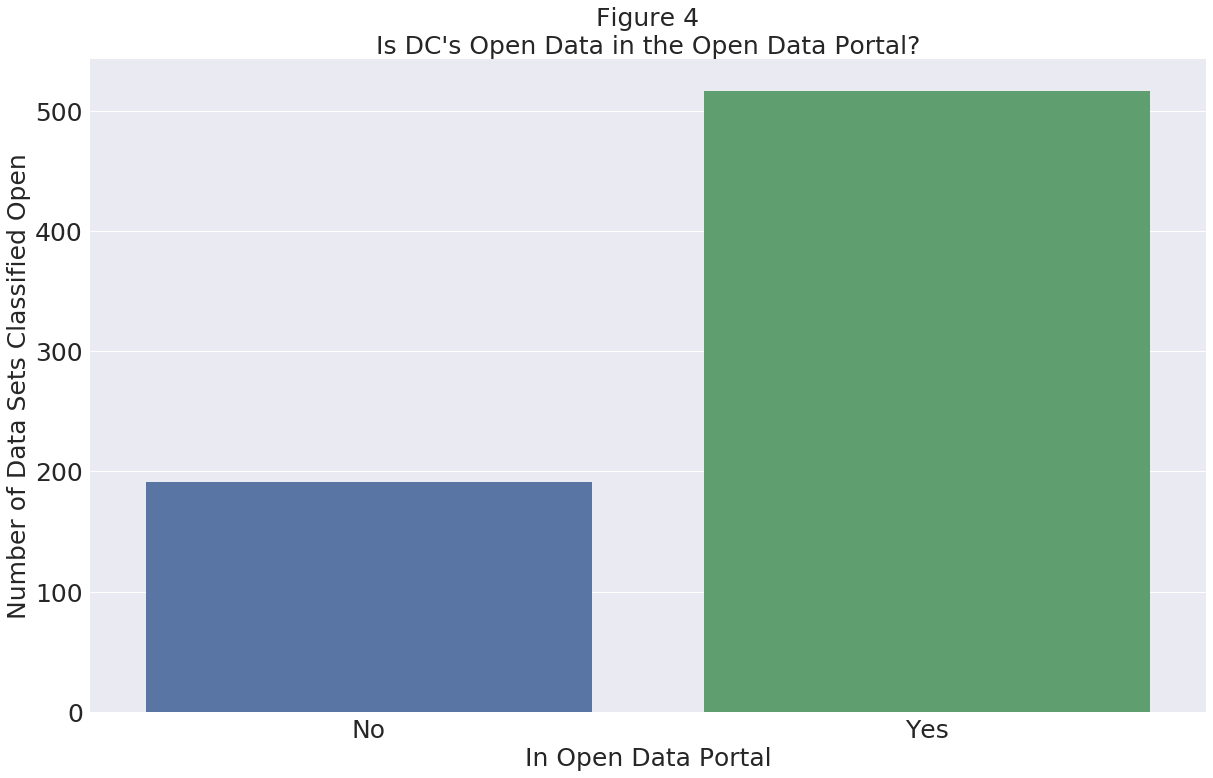

In [10]:
print('Data Sets in Open Data Portal: ' +str(df[df.OPENDATA_PORTAL=='Yes'].shape[0]))
print('Data Sets Classified \'Open\': ' +str(df[df.DATASET_CLASSIFICATION_NAME=='Open'].shape[0]))
print('Open Data Sets not in Open Data Portal: ' +str(df[(df.DATASET_CLASSIFICATION_NAME == 'Open') & (df.OPENDATA_PORTAL == 'No')].shape[0]))

open_data = df[df.DATASET_CLASSIFICATION_NAME=='Open']
print(open_data.OPENDATA_PORTAL.value_counts().sort_index())
print(100 * round(open_data.OPENDATA_PORTAL.value_counts().sort_index()/len(open_data), 3))

fig, (ax) = plt.subplots(1,1,figsize = (20,12))

sns.barplot(np.sort(open_data.OPENDATA_PORTAL.unique()), open_data.OPENDATA_PORTAL.value_counts().sort_index(), ax=ax)
ax.set_xlabel('In Open Data Portal', fontsize = 25)
ax.set_ylabel('Number of Data Sets Classified Open', fontsize=25)
ax.set_xticklabels(['No', 'Yes'])
ax.tick_params(which = 'major', labelsize = 25)
ax.set_title('Figure 4\nIs DC\'s Open Data in the Open Data Portal?', fontsize=25)

## Data Set Category

Government Operations                  207
Health                                 175
Transportation                         165
Education                              145
Public Services                        122
Public Safety                          122
Business and Economic Development      108
Administrative and Other Boundaries    102
Environment                             98
Utility and Communication               64
Property and Land                       60
Planning Land Use and Zoning            46
Financial                               45
Aerial Photography and Scanned Maps     42
Historic                                32
Facility and Structure                  22
Demographic                             21
Cultural and Society                    20
Recreation                              17
Location                                11
Technology                               6
Elevation                                5
Communication                            4
Basemap    

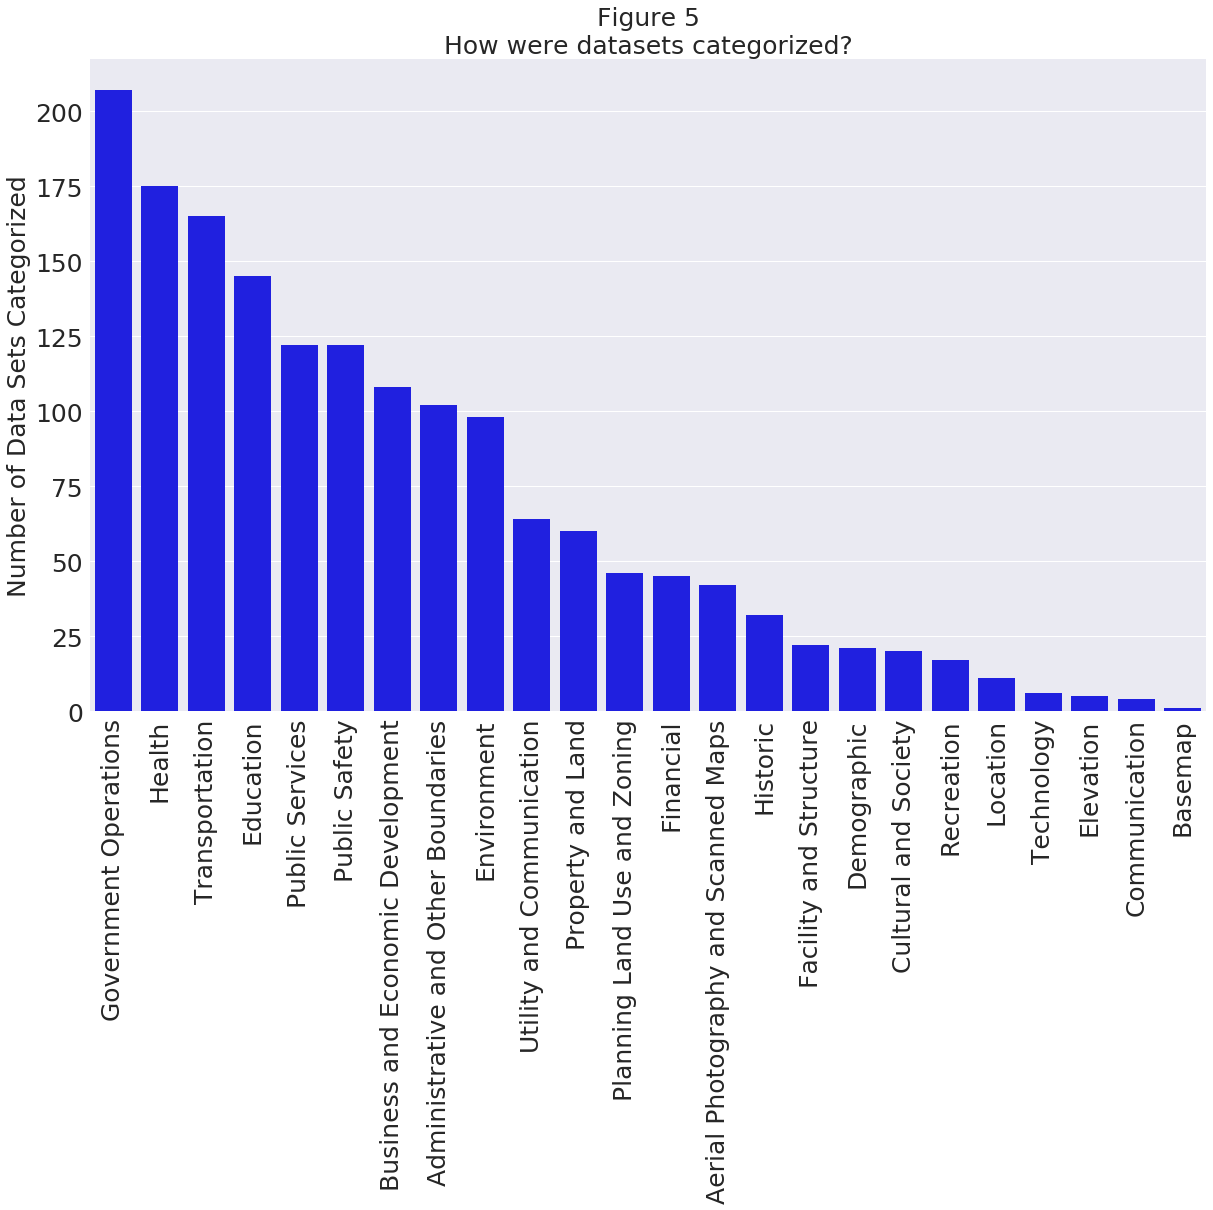

In [11]:
categories = pd.DataFrame(df.DATASET_CATEGORY.value_counts())
categories = categories[categories.index != '-1']

print(categories.DATASET_CATEGORY)

fig, ax = plt.subplots(figsize = (20,12))
sns.barplot(categories.index, categories.DATASET_CATEGORY, ax=ax, color = 'blue')
plt.xticks(rotation=90)
ax.tick_params(which = 'major', labelsize = 25)
ax.set_ylabel('Number of Data Sets Categorized', fontsize=25)
ax.set_title('Figure 5\nHow were datasets categorized?', fontsize=25)